# Quick RGB Composite for Nickel data
---------------------------------------------------------------

Y.S.Murakami, UCB, sterling.astro@berkeley.edu

**Demo data**: SN2020hvp. UCB SNe Search Team, Nickel 1-m telescope, Lick Observatory

**This code:**
* imports RGB data
* corrects pointing offset (image-based)
* visualizes flux distribution
* generates RGB image

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from scipy.ndimage import interpolation as interp
from skimage.registration import phase_cross_correlation

In [3]:
def img_scale_log(inputArray, scale_min, scale_max):
    imageData=np.array(inputArray, copy=True)

    # saturation clipping: uncomment to turn it on
#     saturation_threshold = 60000 #anything brighter than this is considered as CR and is changed to 0
#     indices0 = imageData >= saturation_threshold
#     imageData[indices0] = 0
    
    if scale_min == None:
        scale_min = imageData.min()
    if scale_max == None:
        scale_max = imageData.max()
    factor = np.log10(scale_max) - np.log10(scale_min)
    lower_lim = np.log10(scale_min)
    
    imageData = (np.log10(imageData)-lower_lim)/factor
    
    indices1 = imageData <= 0 
    indices2 = imageData == -np.inf
    indices3 = imageData >= 1
    
    imageData[indices1] = 0
    imageData[indices2] = 0
    imageData[indices3] = 1

    return imageData

# (1) Prepare data

In [4]:
Rdata = fits.getdata('tfn200525.d158.2020hvp.R.fit')
Gdata = fits.getdata('tfn200525.d157.2020hvp.V.fit')
Bdata = fits.getdata('tfn200525.d156.2020hvp.B.fit')

# (2) Determine scaling parameters

In [5]:
print(Rdata.max())
print(Gdata.max())
print(Bdata.max())

67960.296875
69431.0546875
46109.44921875


In [6]:
# correct pointing offset automatically (using Bdata as a reference)
shift, error, diffphase = phase_cross_correlation(Bdata.astype('int'), Rdata.astype('int'))
new_R = interp.shift(Rdata, shift)
shift, error, diffphase = phase_cross_correlation(Bdata.astype('int'), Gdata.astype('int'))
new_G = interp.shift(Gdata, shift)

R = new_R
G = new_G
B = Bdata

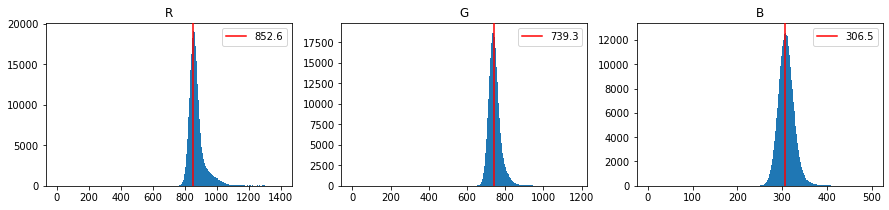

In [9]:
# check histogram: the peak value is a rough estimation of the lower limit ('black' level)
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,3))

y,bins,_ = ax1.hist(Rdata.flatten(),bins=1000,range=(0,np.mean(Rdata.flatten())+1*np.std(Rdata.flatten())))
peak = ((bins[1:]+bins[:-1])/2)[y==y.max()]
ax1.axvline(peak,c='red',zorder=5,label='{:.1f}'.format(*peak))
ax1.set_title('R')
ax1.legend()

y,bins,_ = ax2.hist(Gdata.flatten(),bins=1000,range=(0,np.mean(Gdata.flatten())+1*np.std(Gdata.flatten())))
peak = ((bins[1:]+bins[:-1])/2)[y==y.max()]
ax2.axvline(peak,c='red',zorder=5,label='{:.1f}'.format(*peak))
ax2.set_title('G')
ax2.legend()

y,bins,_ = ax3.hist(Bdata.flatten(),bins=1000,range=(0,np.mean(Bdata.flatten())+1*np.std(Bdata.flatten())))
peak = ((bins[1:]+bins[:-1])/2)[y==y.max()]
ax3.axvline(peak,c='red',zorder=5,label='{:.1f}'.format(*peak))
ax3.set_title('B');
ax3.legend()
plt.show()

# (3) Generate Image (keep changing parameters until it looks right!)

In [177]:
# generate image

# reference: Jessica Lu's blog post
# https://www.astrobetter.com/blog/2010/10/22/making-rgb-images-from-fits-files-with-pythonmatplotlib/
# scale_min: 'black' level. This is usually histogram peak + small offset.
# scale_max: 'white' level. Lowering this will cause more saturation, but will make the image brighter.
img = np.zeros((R.shape[0], R.shape[1], 3), dtype=float)
img[:,:,0] = img_scale_log(R, scale_min=855, scale_max=1700)
img[:,:,1] = img_scale_log(G, scale_min=740, scale_max=1200)
img[:,:,2] = img_scale_log(B, scale_min=310, scale_max=480)

In [178]:
# Color noise reduction
# detect noise when single color value is too different from other two colors

# noise_level: lower limit of single-color noise level. Lowering this will remove more noise
#              but also possibly more actual data.

# background_level: upper limit of the background color
#                   (e.g. red- and blue- color level when removing green-color noise)
#                   Increasing this will remove more noise, but possibly more actual data.

noise_level = 0.8
background_level = 0.3
indices_Rnoise = (img[:,:,0]>=noise_level) & ((img[:,:,1]<=background_level) & (img[:,:,2]<=background_level))
indices_Gnoise = (img[:,:,1]>=noise_level) & ((img[:,:,0]<=background_level) & (img[:,:,2]<=background_level))
indices_Bnoise = (img[:,:,2]>=noise_level) & ((img[:,:,1]<=background_level) & (img[:,:,0]<=background_level))

img[indices_Rnoise] = 0
img[indices_Gnoise] = 0
img[indices_Bnoise] = 0

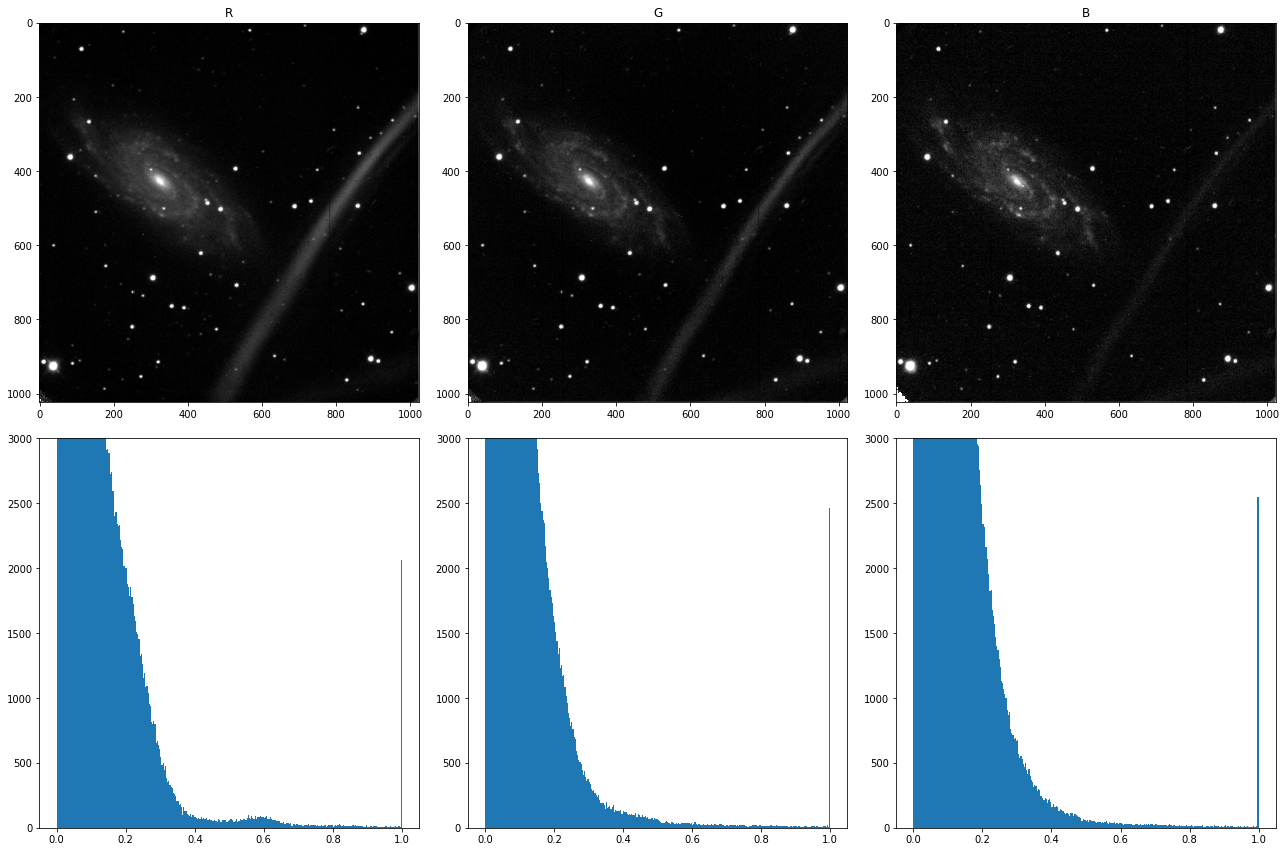

In [179]:
# individual color
# use this to check the parameters used in 'generate image' cell
# Resulting histogram should look similar to each other between all colors.

fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(18,12))
ax1.imshow(img[:,:,0],cmap='gray')
ax1.set_title('R')
ax2.imshow(img[:,:,1],cmap='gray')
ax2.set_title('G')
ax3.imshow(img[:,:,2],cmap='gray')
ax3.set_title('B')

ax4.hist(np.array(img[:,:,0]).flatten(),bins=300)
ax4.set_ylim(0,3000)
ax5.hist(np.array(img[:,:,1]).flatten(),bins=300)
ax5.set_ylim(0,3000)
ax6.hist(np.array(img[:,:,2]).flatten(),bins=300)
ax6.set_ylim(0,3000)
plt.tight_layout()
plt.savefig('RGB_individual+histogram',dpi=100)

# (4) Final Image

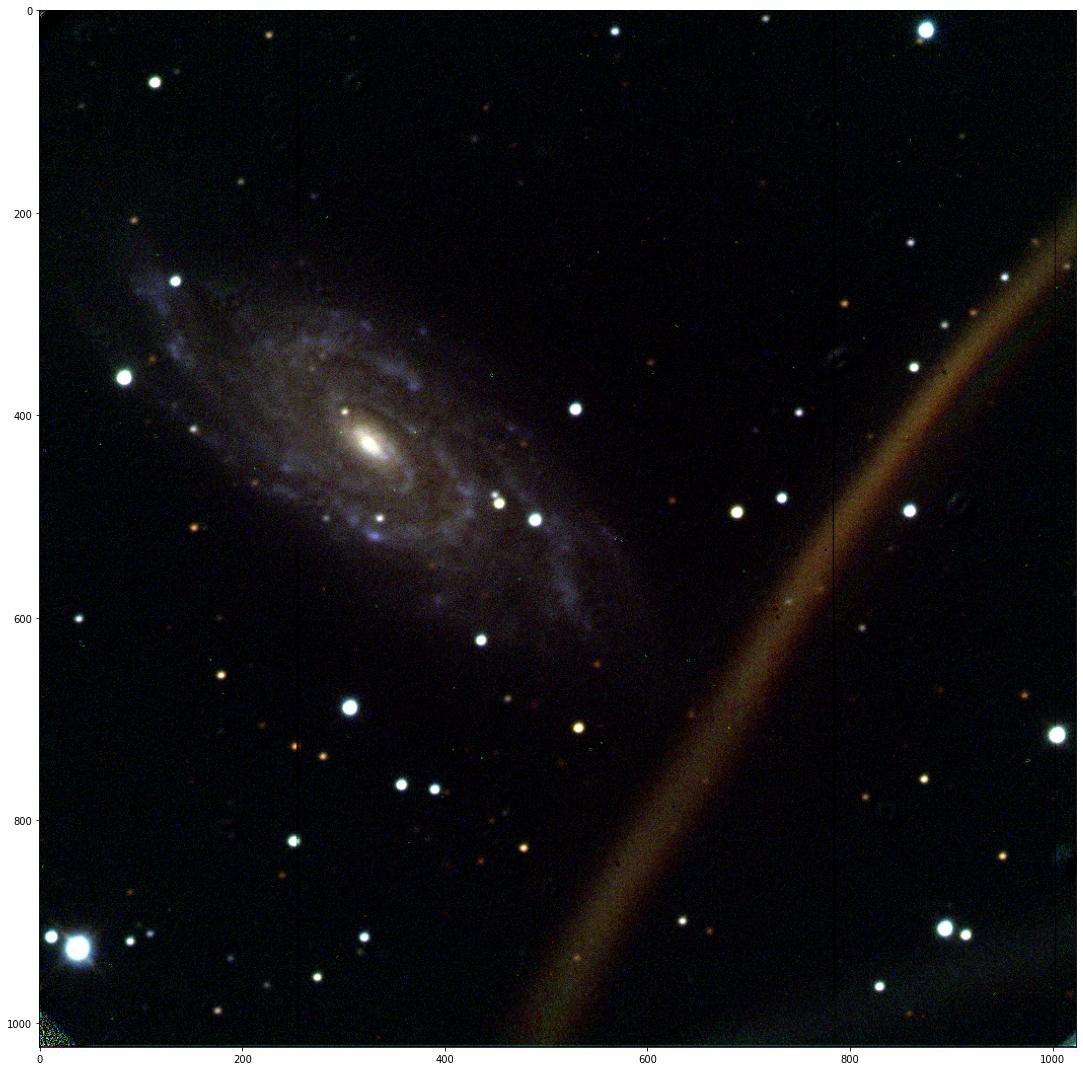

In [180]:
# final image
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.tight_layout()
plt.savefig('rgb01',dpi=200)